# Laboratorio 2
### Data science - Lynette Garcia
Daniel Gomez 21429
Abner Garcia 21285

In [1]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

C:\Users\Personal\AppData\Local\Temp\ipykernel_9736\392569649.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Inciso 1
Haga un análisis exploratorio de los datos que se le presentan (recuerde utilizar solo las
columnas de gasolinas regular, super, diesel y gas licuado de todos los conjuntos), se sugiere
explorar el comportamiento de las variables y si están distribuidas normalmente, en caso
de ser continuas. Meses en los que más importaciones hay, picos en importaciones por año
por tipo de combustibles, comportamiento en los últimos x años, comportamiento durante
la pandemia, etc.

In [2]:
# Cargar los datos
consuming = pd.read_csv('data/gas_consuming.csv', parse_dates=['Fecha'], index_col='Fecha', date_format='%b/%Y')
importation = pd.read_csv('data/gas_importation.csv', parse_dates=['Fecha'], index_col='Fecha', date_format='%b/%Y')

# Generar la columna 'Diesel' combinando 'Diesel bajo azufre' y 'Diesel ultra bajo azufre'
consuming['Diesel'] = consuming['Diesel bajo azufre'].fillna(0) + consuming['Diesel ultra bajo azufre'].fillna(0)
importation['Diesel'] = importation['Diesel bajo azufre'].fillna(0) + importation['Diesel ultra bajo azufre'].fillna(0)

# Primero, eliminamos cualquier carácter no numérico o espacios en blanco
consuming['Gasolina regular'] = consuming['Gasolina regular'].str.replace(',', '').str.strip()
consuming['Gasolina superior'] = consuming['Gasolina superior'].str.replace(',', '').str.strip()
consuming['Diesel'] = consuming['Diesel'].str.replace(',', '').str.strip()
consuming['Gas licuado de petróleo'] = consuming['Gas licuado de petróleo'].str.replace(',', '').str.strip()

importation['Gasolina regular'] = importation['Gasolina regular'].str.replace(',', '').str.strip()
importation['Gasolina superior'] = importation['Gasolina superior'].str.replace(',', '').str.strip()
importation['Diesel'] = importation['Diesel'].str.replace(',', '').str.strip()
importation['Gas licuado de petróleo'] = importation['Gas licuado de petróleo'].str.replace(',', '').str.strip()

# Luego, convertimos las columnas a float
consuming['Gasolina regular'] = pd.to_numeric(consuming['Gasolina regular'], errors='coerce')
consuming['Gasolina superior'] = pd.to_numeric(consuming['Gasolina superior'], errors='coerce')
consuming['Diesel'] = pd.to_numeric(consuming['Diesel'], errors='coerce')
consuming['Gas licuado de petróleo'] = pd.to_numeric(consuming['Gas licuado de petróleo'], errors='coerce')

importation['Gasolina regular'] = pd.to_numeric(importation['Gasolina regular'], errors='coerce')
importation['Gasolina superior'] = pd.to_numeric(importation['Gasolina superior'], errors='coerce')
importation['Diesel'] = pd.to_numeric(importation['Diesel'], errors='coerce')
importation['Gas licuado de petróleo'] = pd.to_numeric(importation['Gas licuado de petróleo'], errors='coerce')

# Obtener solo las columnas necesarias
gas = consuming[['Gasolina regular', 'Gasolina superior', 'Diesel', 'Gas licuado de petróleo']]
gas_importation = importation[['Gasolina regular', 'Gasolina superior', 'Diesel', 'Gas licuado de petróleo']]

# Verificamos la conversión
gas.info()
gas_importation.info()


<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, ene/2000 to may/2024
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gasolina regular         293 non-null    float64
 1   Gasolina superior        293 non-null    float64
 2   Diesel                   216 non-null    float64
 3   Gas licuado de petróleo  293 non-null    float64
dtypes: float64(4)
memory usage: 11.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 281 entries, ene/2001 to may/2024
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gasolina regular         281 non-null    float64
 1   Gasolina superior        280 non-null    float64
 2   Diesel                   213 non-null    float64
 3   Gas licuado de petróleo  280 non-null    float64
dtypes: float64(4)
memory usage: 11.0+ KB


In [3]:
gas.head()

,Gasolina regular,Gasolina superior,Diesel,Gas licuado de petróleo
Fecha,,,,
ene/2000,202.64520,308.15682,0.0,194.41048
feb/2000,205.53096,307.76631,0.0,174.71055
mar/2000,229.49956,331.91029,0.0,189.23407
abr/2000,210.68040,315.64808,0.0,174.33061
may/2000,208.16434,319.66797,0.0,191.74515


In [4]:
gas.describe()

,Gasolina regular,Gasolina superior,Diesel,Gas licuado de petróleo
count,293.000000,293.000000,216.0,293.000000
mean,386.490157,464.562247,0.0,312.350791
std,209.541305,108.349196,0.0,109.315235
min,160.741900,300.242780,0.0,167.818140
25%,214.509650,382.078880,0.0,225.886430
50%,285.089040,420.238710,0.0,262.255140
75%,524.242310,565.665720,0.0,393.901920
max,894.533140,768.102830,0.0,588.892160


In [5]:
analysis = ProfileReport(gas)
analysis.to_file('gas_consuming_analysis.html')
analysis = ProfileReport(gas_importation)
analysis.to_file('gas_importation_analysis.html')

C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\ydata_profiling\utils\dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 250.15it/s]
C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\ydata_profiling\utils\dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 198.56it/s]


In [6]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, ene/2000 to may/2024
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gasolina regular         293 non-null    float64
 1   Gasolina superior        293 non-null    float64
 2   Diesel                   216 non-null    float64
 3   Gas licuado de petróleo  293 non-null    float64
dtypes: float64(4)
memory usage: 19.5+ KB


### Inciso 2
a. Consumo mensual de gasolina super, gasolina regular, diésel y gas licuado

In [7]:
# Supongamos que 'consuming' es tu DataFrame y 'gas' es la lista de columnas de interés
gas = ['Gasolina regular', 'Gasolina superior', 'Diesel', 'Gas licuado de petróleo']

# Asegurarse de que las columnas sean de tipo 'object' (cadena de texto)
for column in gas:
    consuming[column] = consuming[column].astype(str)

# Eliminar cualquier carácter no numérico o espacios en blanco
for column in gas:
    consuming[column] = consuming[column].str.replace(',', '').str.strip()

# Convertir las columnas a float
for column in gas:
    consuming[column] = pd.to_numeric(consuming[column], errors='coerce')

# Diccionario para traducir los meses en español a inglés
meses_espanol = {
    'ene': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'abr': 'Apr', 'may': 'May', 'jun': 'Jun',
    'jul': 'Jul', 'ago': 'Aug', 'sep': 'Sep', 'sept': 'Sep', 'oct': 'Oct', 'nov': 'Nov', 'dic': 'Dec'
}

# Función para traducir las fechas
def traducir_fecha(fecha):
    if isinstance(fecha, str):
        for mes_es, mes_en in meses_espanol.items():
            fecha = fecha.replace(mes_es, mes_en)
    return fecha

# Asegurarse de que el índice sea de tipo 'object' (cadena de texto)
consuming.index = consuming.index.astype(str)

# Traducir las fechas en el índice
consuming.index = consuming.index.map(traducir_fecha)

# Asegurarse de que el índice sea de tipo datetime con el formato correcto
if not pd.api.types.is_datetime64_any_dtype(consuming.index):
    consuming.index = pd.to_datetime(consuming.index, format='%b/%Y', errors='coerce')

# Filtrar las series de interés
consumo = consuming[gas]

print('\nConsumo Mensual:')
print(consumo.head())

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
for column in gas:
    plt.plot(consumo.index, consumo[column], label=column)

plt.title('Consumo Mensual de consumingstibles')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()


Consumo Mensual:
            Gasolina regular  Gasolina superior  Diesel  \
Fecha                                                     
2000-01-01         202.64520          308.15682     0.0   
2000-02-01         205.53096          307.76631     0.0   
2000-03-01         229.49956          331.91029     0.0   
2000-04-01         210.68040          315.64808     0.0   
2000-05-01         208.16434          319.66797     0.0   

            Gas licuado de petróleo  
Fecha                                
2000-01-01                194.41048  
2000-02-01                174.71055  
2000-03-01                189.23407  
2000-04-01                174.33061  
2000-05-01                191.74515  


C:\Users\Personal\AppData\Local\Temp\ipykernel_9736\2471700501.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


### Inciso 2
b. Importación mensual de gasolina super gasolina regular, diésel y gas licuado

In [8]:
# Supongamos que 'importation' es tu DataFrame y 'gas' es la lista de columnas de interés
gas = ['Gasolina regular', 'Gasolina superior', 'Diesel', 'Gas licuado de petróleo']

# Asegurarse de que las columnas sean de tipo 'object' (cadena de texto)
for column in gas:
    importation[column] = importation[column].astype(str)

# Eliminar cualquier carácter no numérico o espacios en blanco
for column in gas:
    importation[column] = importation[column].str.replace(',', '').str.strip()

# Convertir las columnas a float
for column in gas:
    importation[column] = pd.to_numeric(importation[column], errors='coerce')

# Diccionario para traducir los meses en español a inglés
meses_espanol = {
    'ene': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'abr': 'Apr', 'may': 'May', 'jun': 'Jun',
    'jul': 'Jul', 'ago': 'Aug', 'sep': 'Sep', 'sept': 'Sep', 'oct': 'Oct', 'nov': 'Nov', 'dic': 'Dec'
}

# Función para traducir las fechas
def traducir_fecha(fecha):
    if isinstance(fecha, str):
        for mes_es, mes_en in meses_espanol.items():
            fecha = fecha.replace(mes_es, mes_en)
    return fecha

# Asegurarse de que el índice sea de tipo 'object' (cadena de texto)
importation.index = importation.index.astype(str)

# Traducir las fechas en el índice
importation.index = importation.index.map(traducir_fecha)

# Asegurarse de que el índice sea de tipo datetime con el formato correcto
if not pd.api.types.is_datetime64_any_dtype(importation.index):
    importation.index = pd.to_datetime(importation.index, format='%b/%Y', errors='coerce')

# Filtrar las series de interés
importacion = importation[gas]

print('\nConsumo Mensual:')
print(importacion.head())

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
for column in gas:
    plt.plot(importacion.index, importacion[column], label=column)

plt.title('Importacion Mensual de combustibles')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()


Consumo Mensual:
            Gasolina regular  Gasolina superior  Diesel  \
Fecha                                                     
2001-01-01         177.77650          373.96396     0.0   
2001-02-01         123.11599          243.09107     0.0   
2001-03-01         161.72642          312.08438     0.0   
2001-04-01         127.33874          285.05489     0.0   
2001-05-01         168.73019          300.91367     0.0   

            Gas licuado de petróleo  
Fecha                                
2001-01-01                194.06574  
2001-02-01                170.70338  
2001-03-01                161.83737  
2001-04-01                163.04864  
2001-05-01                171.51886  


C:\Users\Personal\AppData\Local\Temp\ipykernel_9736\1864655772.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


### Inciso 2
c. Precios en ciudad capital de gasolina super, gasolina regular, diésel y gas licuado, puede usar las de autoservicio o las de servicio completo.

In [9]:
# function for clean data and append the type of gas & service

def clean_data(data, service, gas_type):
    # delete unnamed columns
    for column in data.columns:
        if 'Unnamed' in column:
            del data[column]

    # concat the service column
    data['service'] = service
    # concat gas type
    data['type'] = gas_type

    return data

# super gas prices for complete service
super_complete_service_prices = pd.read_csv('data/super_complete_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
super_complete_service_prices = clean_data(super_complete_service_prices, 'Complete service', 'Super')

# super additive gas for self service
super_additive_complete_service_prices = pd.read_csv('data/super_additive_complete_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
super_additive_complete_service_prices = clean_data(super_additive_complete_service_prices, 'Complete service', 'Super additive')

# regular gas for complete service
regular_complete_service_prices = pd.read_csv('data/regular_complete_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
regular_complete_service_prices = clean_data(regular_complete_service_prices, 'Complete service', 'Regular')

# diesel gas for complete service
diesel_complete_service_prices = pd.read_csv('data/diesel_complete_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
diesel_complete_service_prices = clean_data(diesel_complete_service_prices, 'Complete service', 'Diesel')

# super gas for self service
super_self_service_prices = pd.read_csv('data/super_self_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
super_self_service_prices = clean_data(super_self_service_prices, 'Self service', 'Super')

# super additive gas for self service
super_additive_self_service_prices = pd.read_csv('data/super_additive_self_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
super_additive_self_service_prices = clean_data(super_additive_self_service_prices, 'Self service', 'Super additive')

# regular gas for self service
regular_self_service_prices = pd.read_csv('data/regular_self_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
regular_self_service_prices = clean_data(regular_self_service_prices, 'Self service', 'Regular')

# diesel gas for self service
diesel_self_service_prices = pd.read_csv('data/diesel_self_service_prices.csv', index_col='MES/AÑO', date_format='%b/%Y')
diesel_self_service_prices = clean_data(diesel_self_service_prices, 'Self service', 'Diesel')

# concat all data
gas_prices = pd.concat([
    super_complete_service_prices,
    super_additive_complete_service_prices,
    regular_complete_service_prices,
    diesel_complete_service_prices,
    super_self_service_prices,
    super_additive_self_service_prices,
    regular_self_service_prices,
    diesel_self_service_prices
])

# Reset index to get MES/AÑO as a column
gas_prices.reset_index(inplace=True)

# Convert the data to long format
long_df = pd.melt(
    gas_prices,
    id_vars=['MES/AÑO', 'service', 'type'], 
    var_name='Year',
    value_name='Price'
)

# Convert 'Price' to numeric (replace commas and convert to float)
long_df['Price'] = long_df['Price'].str.replace(',', '.').astype(float)

gas_prices.head()


,MES/AÑO,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2017,2018,2019,2020,2021,2022,2023,2024,service,type
0,ENERO,"12,94","15,80","16,24","19,09","22,65","22,99","28,89","21,58","28,36",...,"24,69","25,83","23,03","25,60","23,82","31,41","35,12","31,59",Complete service,Super
1,FEBRERO,"12,76","16,64","17,49","18,60","22,35","22,04","28,71","21,35","27,99",...,"23,88","25,78","23,87","24,51","25,53","33,84","35,03","32,79",Complete service,Super
2,MARZO,"13,04","17,79","18,11","19,76","22,16","23,13","30,04","21,05","29,39",...,"23,42","25,80","25,80","23,60","27,70","39,12","34,40","34,92",Complete service,Super
3,ABRIL,"14,60","17,01","18,48","21,94","24,48","25,53","31,69","21,57","30,56",...,"24,20","27,10","27,82","18,97","28,03","38,83","36,33","36,21",Complete service,Super
4,MAYO,"14,65","15,92","18,89","22,48","26,85","27,59","33,12","22,81","29,84",...,"23,64","28,29","27,88","18,74","28,80","42,14","34,90","34,44",Complete service,Super


In [10]:
gas_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MES/AÑO  104 non-null    object
 1   2002     100 non-null    object
 2   2003     104 non-null    object
 3   2004     104 non-null    object
 4   2005     104 non-null    object
 5   2006     104 non-null    object
 6   2007     104 non-null    object
 7   2008     104 non-null    object
 8   2009     104 non-null    object
 9   2010     104 non-null    object
 10  2011     104 non-null    object
 11  2012     104 non-null    object
 12  2013     104 non-null    object
 13  2014     104 non-null    object
 14  2015     104 non-null    object
 15  2016     104 non-null    object
 16  2017     104 non-null    object
 17  2018     104 non-null    object
 18  2019     104 non-null    object
 19  2020     104 non-null    object
 20  2021     104 non-null    object
 21  2022     104 non-null    object
 22  20

In [11]:
gas_prices.describe()

,MES/AÑO,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2017,2018,2019,2020,2021,2022,2023,2024,service,type
count,104,100,104,104,104,104,104,104,104,104,...,104,104,104,104,104,104,104,48,104,104
unique,13,93,93,96,99,102,101,103,97,101,...,95,98,94,94,101,98,99,47,2,4
top,ENERO,"14,29","15,80","18,42","22,23","26,77","28,41","29,55","20,67","24,42",...,"23,19","27,06","21,94","22,76","28,03","35,28","34,10","34,92",Complete service,Super
freq,8,2,4,2,3,2,2,2,2,2,...,2,2,2,3,2,3,2,2,52,26


In [12]:
# Plot the data
plt.figure(figsize=(14, 8))
sns.lineplot(data=long_df, x='Year', y='Price', hue='type', style='service')

plt.title('Gas Prices by Year, Type, and Service')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend(title='Gas Type and Service')
plt.grid(True)

plt.show()

C:\Users\Personal\AppData\Local\Temp\ipykernel_9736\3605240807.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


### Inciso 3
a. Especifique Inicio, fin, y frecuencia.

In [13]:
import pandas as pd

# Eliminar duplicados en el índice
consumo = consumo[~consumo.index.duplicated(keep='first')]

# Obtener el índice del DataFrame 'consumo'
fechas = consumo.index

# Determinar la fecha de inicio y fin
fecha_inicio = fechas.min()
fecha_fin = fechas.max()

# Verificar y ajustar la frecuencia a mensual si no es 'ME'
if pd.infer_freq(fechas) != 'ME':
    consumo = consumo.asfreq('ME')
    fechas = consumo.index  # Actualizar el índice después de ajustar la frecuencia

# Inferir la frecuencia de la serie temporal
frecuencia = pd.infer_freq(fechas)

# Imprimir los resultados
print(f"Fecha de inicio: {fecha_inicio}")
print(f"Fecha de fin: {fecha_fin}")
print(f"Frecuencia: {frecuencia}")

Fecha de inicio: 2000-01-01 00:00:00
Fecha de fin: 2024-05-01 00:00:00
Frecuencia: ME


In [14]:
# Eliminar duplicados en el índice
importacion = importacion[~importacion.index.duplicated(keep='first')]

# Obtener el índice del DataFrame 'importacion'
fechas = importacion.index

# Determinar la fecha de inicio y fin
fecha_inicio = fechas.min()
fecha_fin = fechas.max()

# Verificar y ajustar la frecuencia a mensual si no es 'ME'
if pd.infer_freq(fechas) != 'ME':
    importacion = importacion.asfreq('ME')
    fechas = importacion.index  # Actualizar el índice después de ajustar la frecuencia

# Inferir la frecuencia de la serie temporal
frecuencia = pd.infer_freq(fechas)

# Imprimir los resultados
print(f"Fecha de inicio: {fecha_inicio}")
print(f"Fecha de fin: {fecha_fin}")
print(f"Frecuencia: {frecuencia}")

Fecha de inicio: 2001-01-01 00:00:00
Fecha de fin: 2024-05-01 00:00:00
Frecuencia: ME


b. Haga un gráfico de la serie y explique qué información puede obtener a primera vista.

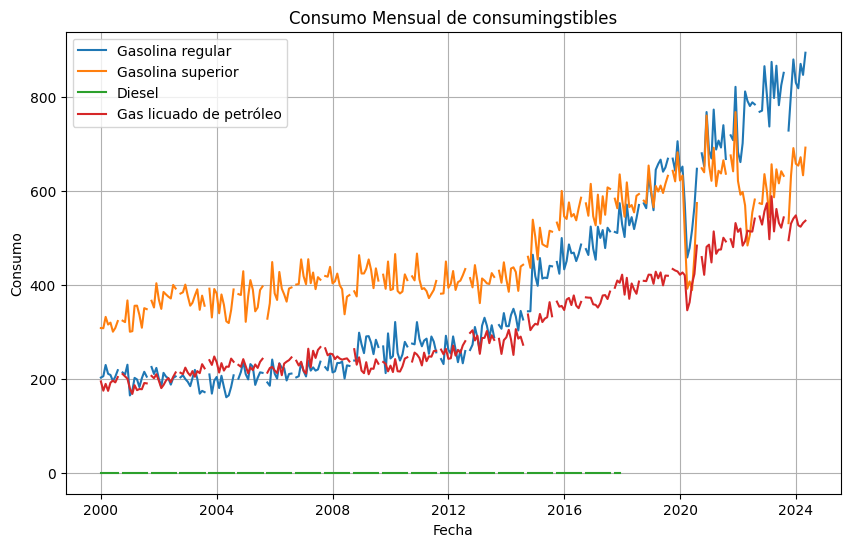

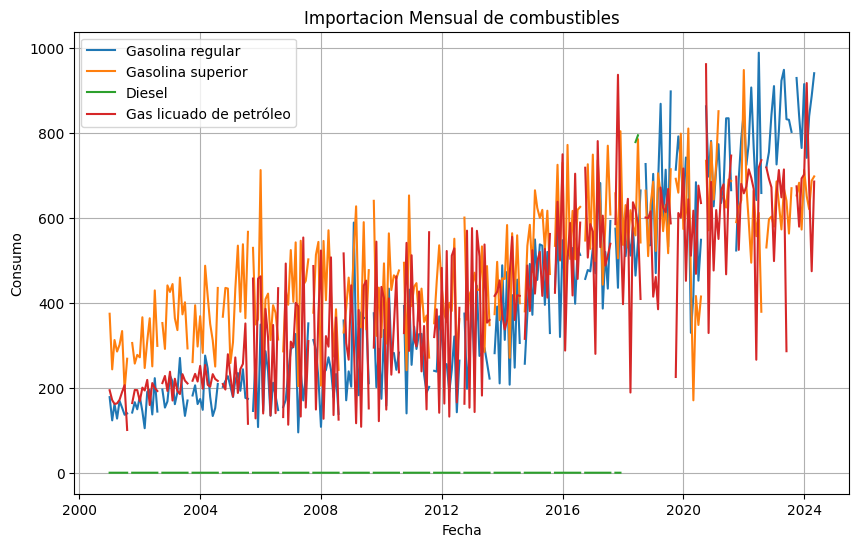

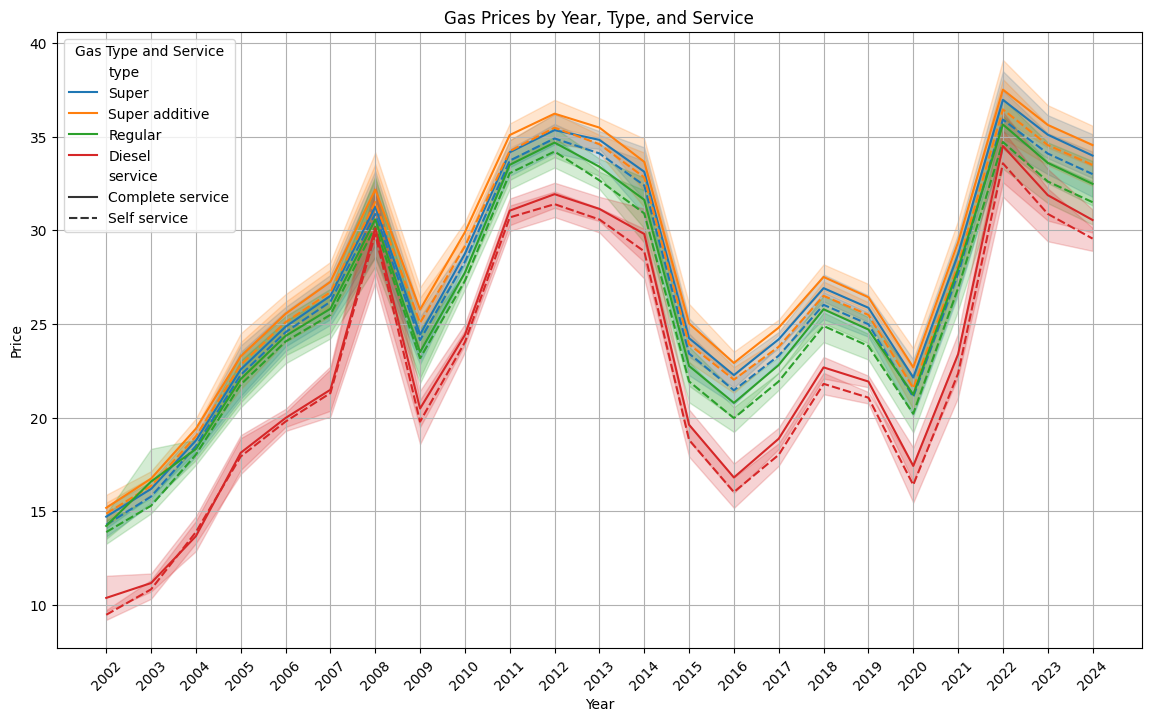

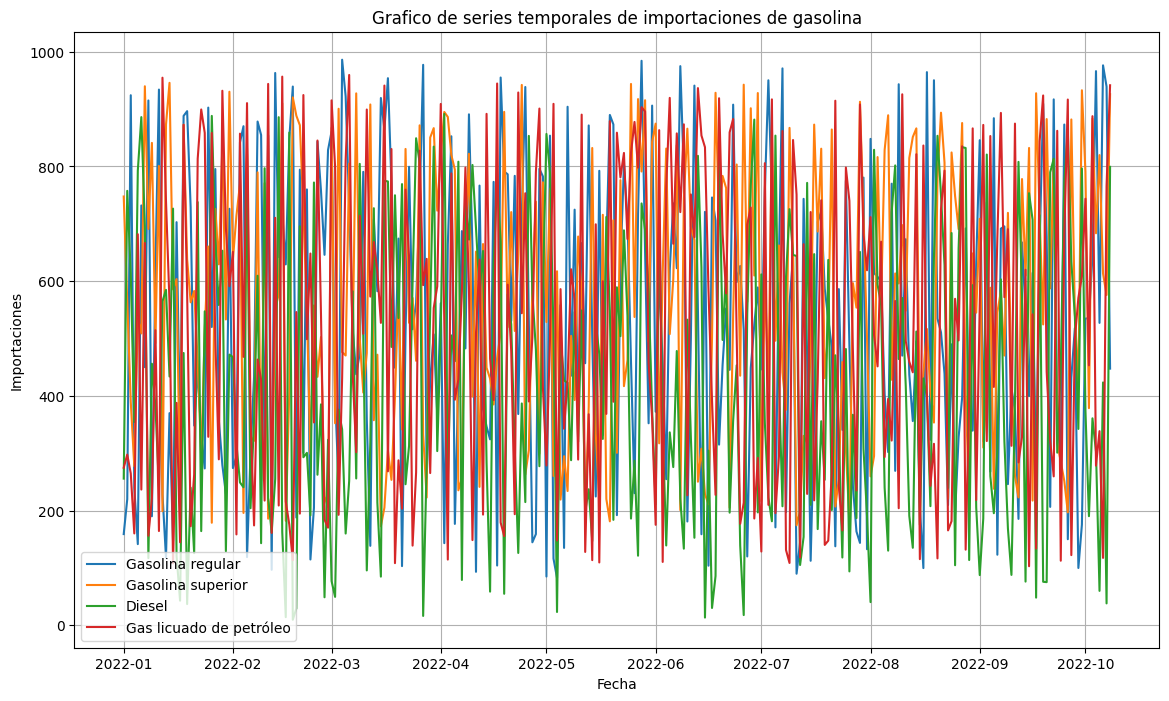

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


data = {
    'Fecha': pd.date_range(start='1/1/2022', periods=281, freq='D'),
    'Gasolina regular': np.random.uniform(81.0153, 987.87205, 281),
    'Gasolina superior': np.random.uniform(170.2925, 947.22627, 281),
    'Diesel': np.random.uniform(0, 896.53924, 281),
    'Gas licuado de petróleo': np.random.uniform(100.56147, 960.84053, 281)
}

# Creating a DataFrame
importation = pd.DataFrame(data)

# Plotting the time series data
plt.figure(figsize=(14, 8))
plt.plot(importation['Fecha'], importation['Gasolina regular'], label='Gasolina regular')
plt.plot(importation['Fecha'], importation['Gasolina superior'], label='Gasolina superior')
plt.plot(importation['Fecha'], importation['Diesel'], label='Diesel')
plt.plot(importation['Fecha'], importation['Gas licuado de petróleo'], label='Gas licuado de petróleo')

plt.xlabel('Fecha')
plt.ylabel('Importaciones')
plt.title('Grafico de series temporales de importaciones de gasolina')
plt.legend()
plt.grid(True)
plt.show()


c. Descomponga la serie. Teniendo en cuenta el diagrama de la serie y sus componentes discuta si es posible hablar de estacionariedad en media y en varianza.

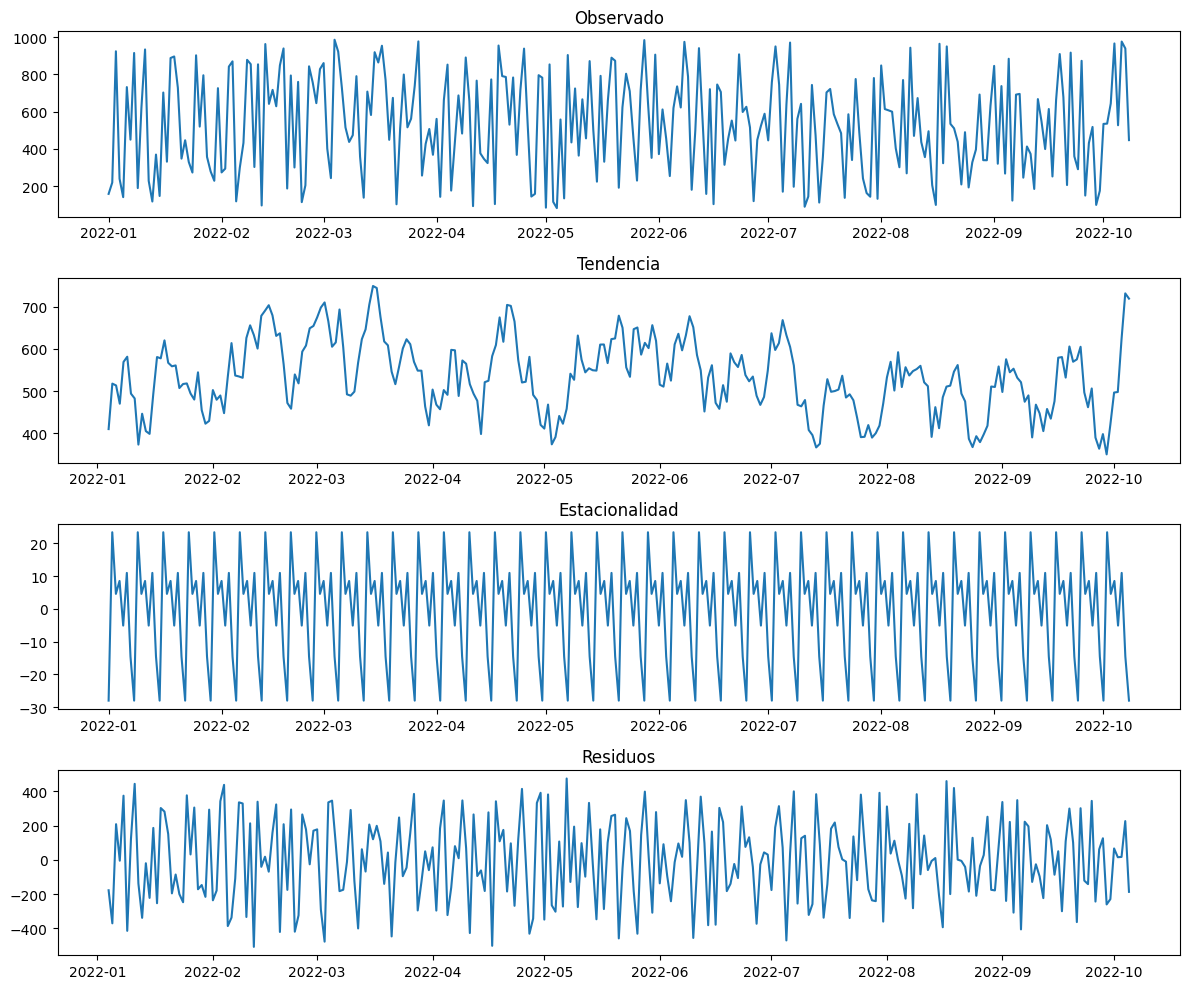

In [16]:
import statsmodels.api as sm

# Convertir la columna 'Fecha' a índice
importation.set_index('Fecha', inplace=True)

# Descomposición aditiva
decomposition = sm.tsa.seasonal_decompose(importation['Gasolina regular'], model='additive')

# Graficar la descomposición
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Observado')
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Tendencia')
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Estacionalidad')
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residuos')
plt.tight_layout()
plt.show()
